Notebook to compare both tasks at the link level using 2-sample paired t-test

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
from pathlib import Path
from os.path import join as opj

from nilearn import image
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.spatial.distance import squareform
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_rel
from sklearn.preprocessing import maxabs_scale
from nilearn.plotting import plot_connectome, find_parcellation_cut_coords

/home/javi/anaconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/home/javi/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
final_subjects = np.loadtxt("../data/subjects_intersect_motion_035.txt")
network_labels = pd.read_csv("../data/atlases/shen_268_parcellation_networklabels.csv")

experiment_dir = Path(glob("../results/experiments/*/shen/pipeline_main.yaml")[0]).parent.as_posix()

pattern = opj(experiment_dir, "task-stroop/edge/sub-%d/Incongruent-Congruent/effect_size.nii.gz")
ef_edge_stroop = np.array([squareform(np.squeeze(image.load_img(pattern % subj).get_fdata()), checks=False) \
                      for subj in final_subjects])

pattern = opj(experiment_dir, "task-msit/edge/sub-%d/Incongruent-Congruent/effect_size.nii.gz")
ef_edge_msit = np.array([squareform(np.squeeze(image.load_img(pattern % subj).get_fdata()), checks=False) \
                      for subj in final_subjects])

In [3]:
res = [ttest_rel(a, b) for a,b in zip(ef_edge_stroop.T, ef_edge_msit.T)]

t_values = np.array([link_res[0] for link_res in res])
p_values = np.array([link_res[1] for link_res in res])
p_values_corrected = multipletests(p_values, method="fdr_bh", alpha=0.05)
print("number of significant links", sum(p_values_corrected[0]))

number of significant links 223


In [4]:
atlas = image.load_img("../data/atlases/shen_2mm_268_parcellation.nii.gz")
shen_coords = find_parcellation_cut_coords(atlas)
pd.DataFrame(shen_coords, columns=["MNI_x", "MNI_y", "MNI_z"]).head()


rsn_names = ["MF", "FP", "DM", "SC", "MT", "V1", "V2", "VA"]

shen_rsns = pd.read_csv("../data/atlases/shen_268_parcellation_networklabels.csv")
shen_rsns["rsn_name"] =shen_rsns.Network.replace(to_replace= [1,2,3,4,5,6,7,8],
                                                 value = rsn_names)

rsn_colors = [[128,0,128], [0,255,255], [255,215,0], [255,69,0],
              [0,0,128], [255,0,255], [0,255,0], [128,0,0]
             ]

node_colors = [tuple([rsn_colors[ii-1][0]/255, rsn_colors[ii-1][1]/255, rsn_colors[ii-1][2]/255]) \
               for ii in shen_rsns.Network.to_list()]

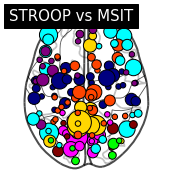

In [5]:
node_size = squareform(p_values_corrected[0]).astype(int).sum(axis=0)
plot_connectome(squareform(p_values_corrected[0]).astype(int), 
                node_coords=shen_coords, 
                node_size=node_size*30, 
                node_color=node_colors,
                edge_cmap = plt.cm.binary,
                alpha=1,
                display_mode='z',
                edge_kwargs={"linewidth": 0,"linestyle": '-.'}, 
                node_kwargs={'edgecolors':'black'}, 
                title="STROOP vs MSIT")
plt.savefig("../plots/differences_tasks_link_degree.svg", dpi=300)
plt.savefig("../plots/differences_tasks_link_degree.png", dpi=300)
plt.savefig("../plots/differences_tasks_link_degree.pdf", dpi=300)

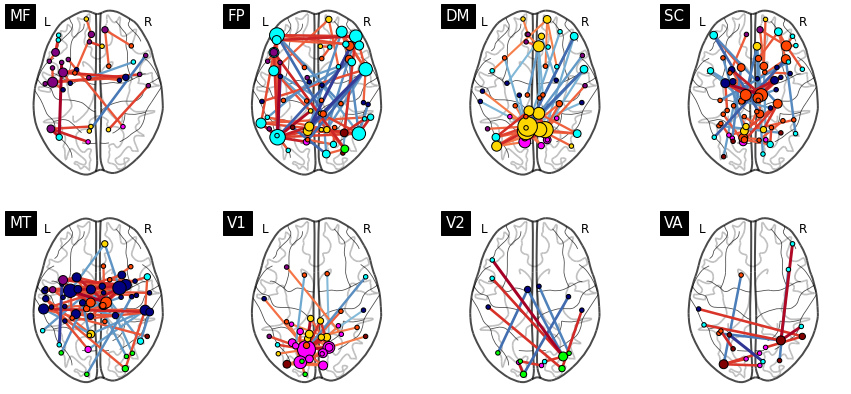

In [6]:
t_thr =t_values*p_values_corrected[0]

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15,7))
axs = axs.flatten()
for ii, label in zip(range(1, 9), rsn_names):
    mask = np.zeros((268, 268))
    mask[shen_rsns.Network==ii,:]=1
    mask[:, shen_rsns.Network==ii]=1
    mask[np.diag_indices_from(mask)]=0
    
    
    A = squareform(maxabs_scale(t_thr*squareform(mask)))
    deg = squareform(p_values_corrected[0]*squareform(mask)).astype(int).sum(axis=0)
    plot_connectome(A, 
                    node_coords=shen_coords, 
                    node_size=deg*20, 
                    node_color=node_colors,
                    edge_cmap = plt.cm.RdYlBu_r,
                    alpha=1,
                    display_mode='z',
                    node_kwargs={'edgecolors':'black'}, 
                    title="%s" % label, axes=axs[ii-1])
    
plt.savefig("../plots/differences_tasks_link_rsn.svg", dpi=300)
plt.savefig("../plots/differences_tasks_link_rsn.png", dpi=300)
plt.savefig("../plots/differences_tasks_link_rsn.pdf", dpi=300)